## Problem 1.
(12 points) Apply PCA on Figure 1 (attached file named as building.png).

Print out the PCA compressed images with rank r = 5, 10, 15, 20, 25, 30.

Compute the corresponding signal to noise ratios(SNR) and collect the SNRs into a table.

Hint: read image (3
points), apply PCA (3 points), display compressed images (3 points), SNRs table (3 points).

In [2]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 26.9 MB/s eta 0:00:0000:0100:01


In [3]:
import requests
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition

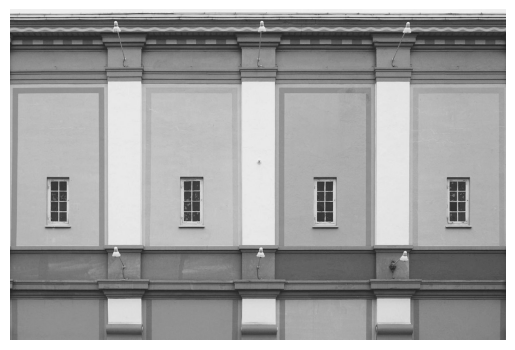

In [4]:
local_image_path = 'building.png'

# Read the image using OpenCV
A = cv2.imread(local_image_path)

# Convert the image to RGB format
image_rgb = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)



plt.imshow(image_rgb)
plt.axis('off')
plt.show()

#A = cv2.imread(image_path)
#print(A.shape)

#plt.imshow(A)

In [5]:
print(A.shape)

(1172, 1758, 3)


In [6]:
A1 = np.mean(A,2) # get 2d array from 3d

In [15]:
def compute_snr(true, est):
    
    S = np.linalg.norm(true, ord='fro')**2
    N = np.linalg.norm(true - est, ord='fro')**2
    
    snr = 10 * np.log10(S/N)
    return snr



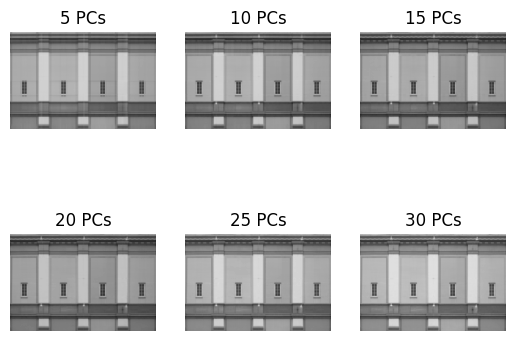

In [16]:
import matplotlib.ticker as tic

components = range(5,31,5)
snr_list = [] # list to store
ranks = []
fig=plt.figure()
for i, num_pc in enumerate(components):
    i+=1

    # Set the number of qulity being used
    pca = decomposition.PCA(n_components=num_pc)
    pca.fit(A1)

    # The reconstruction is done with the inverse_transform method.
    Rec = pca.inverse_transform(pca.transform(A1))

    snr = compute_snr(A1, Rec)
    snr_list.append(snr)
    ranks.append(num_pc)

    # Make subplot
    ax = fig.add_subplot(2,3,i,frame_on=False)

    # Removing ticks
    ax.xaxis.set_major_locator(tic.NullLocator())
    ax.yaxis.set_major_locator(tic.NullLocator())

    plt.imshow(Rec)
    plt.title(str(num_pc) + ' PCs')
    plt.gray()

In [17]:
results = pd.DataFrame({"Rank": ranks, "SNR": snr_list})
results

,Rank,SNR
0,5,23.873662
1,10,26.132420
2,15,27.524761
3,20,28.515171
4,25,29.212810
5,30,29.805506


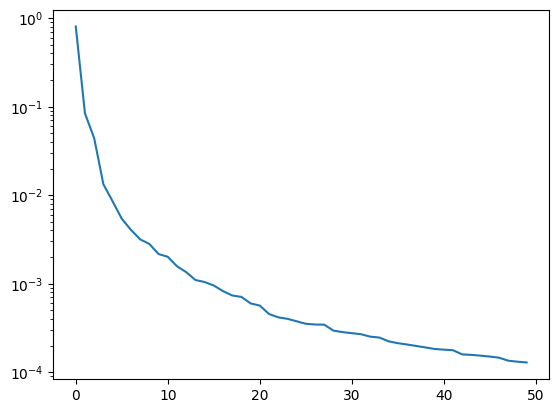

In [18]:
pca1 = decomposition.PCA(n_components=50)
pca1.fit(A1)
var_ratio = pca1.explained_variance_ratio_

#plt.plot(range(0,50),var_ratio)
plt.semilogy(range(0,50),var_ratio)
plt.show()

# Problem 2.
1. (2 points) Go to the website for the Kyushu University’s LIMU Traffic
Intersection dataset at Kyushu University Dataset and download the dataset.

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
from pathlib import Path
from matplotlib import pyplot as plt

from robustpca.general import DATADIR

2. Once downloaded, navigate to the folder containing .jpg images.

3. (3 points) Extract every 50th image from the dataset to create a subset, denoted as D.

In [20]:
frame_paths = sorted(list(Path(DATADIR, 'Intersection').glob('*.jpg')))[::50]
D = list(map(lambda path: cv2.imread(path.as_posix()).mean(-1), frame_paths))
D_res = list(map(lambda frame: cv2.resize(frame, None, fx=0.7, fy=0.7), D))

In [21]:
len(D_res)

100

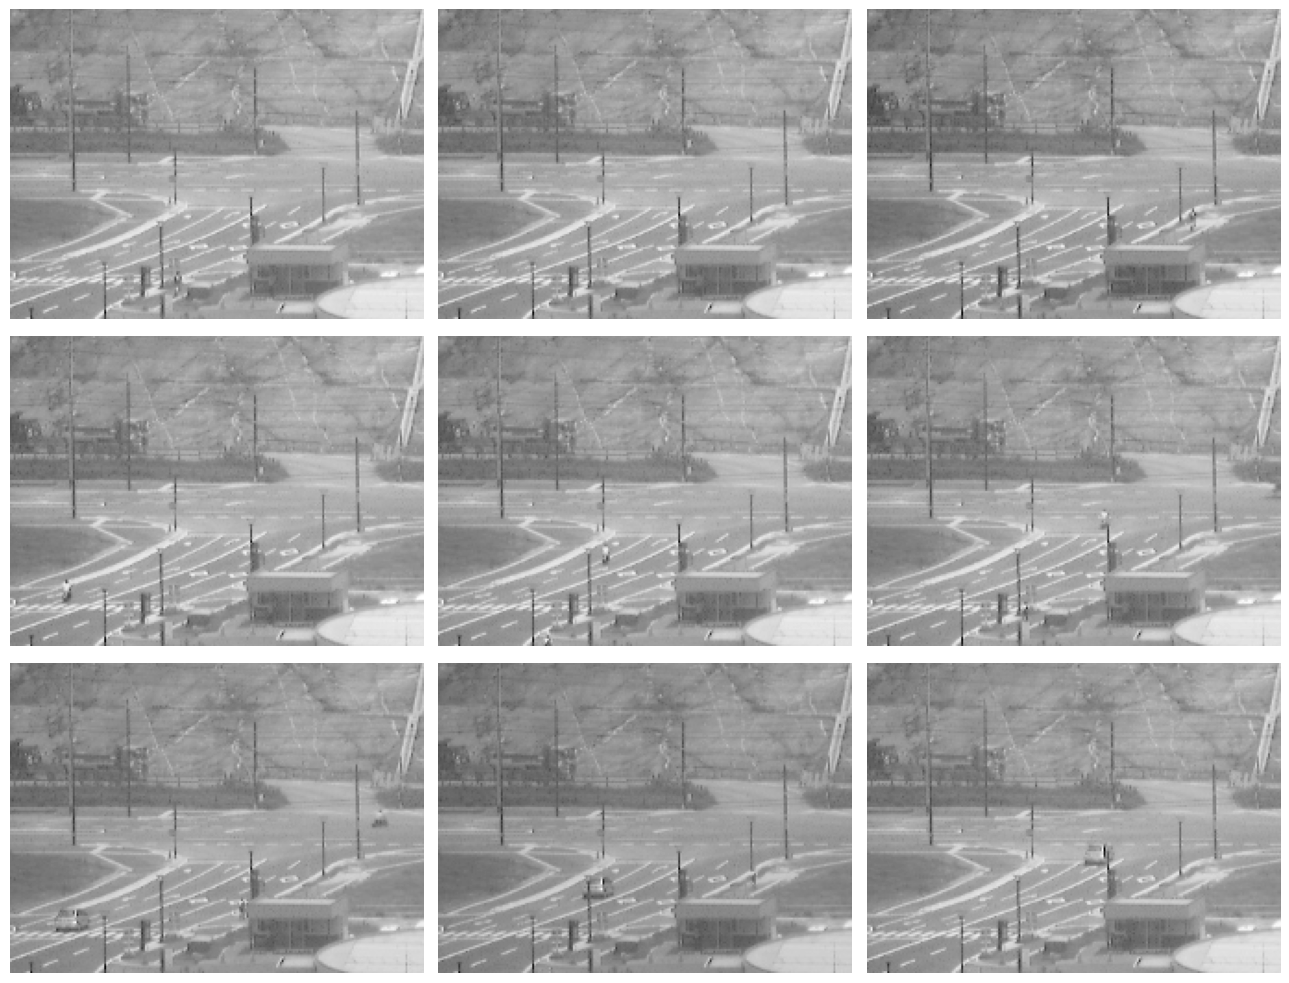

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(13, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(D_res[i], cmap="gray")
    ax.axis("off")

fig.tight_layout()

4. Implement the robust Principal Component Analysis (PCA) algorithms—PCP, Stable PCP, and IRCUR—available at Robust PCA GitHub Repository. These algorithms should be applied to the subset D.

5. (4 points) Refer to the demo mall.ipynb notebook from the repository as a guide for resizing and reshaping D to the appropriate dimensions.


6. Display the first 9 images from D to verify the resizing and reshaping process.

In [31]:
from robustpca.pcp import PCP
from robustpca.pcp import StablePCP
from robustpca.ircur import IRCUR

data_mat = np.stack(D_res, -1).reshape(-1, len(D_res))

PCP

In [24]:
pcp_alm = PCP()
mu = pcp_alm.default_mu(data_mat)
L_pcp, S_pcp = pcp_alm.decompose(data_mat, mu, tol=1e-5, max_iter=500)

Elapsed: 96.16


In [26]:
f'Intrisic rank: {np.linalg.matrix_rank(L_pcp)} | Original rank: {np.linalg.matrix_rank(data_mat)} | Fraction of outliers: {(S_pcp != 0).mean():.3f}'

'Intrisic rank: 50 | Original rank: 100 | Fraction of outliers: 0.962'

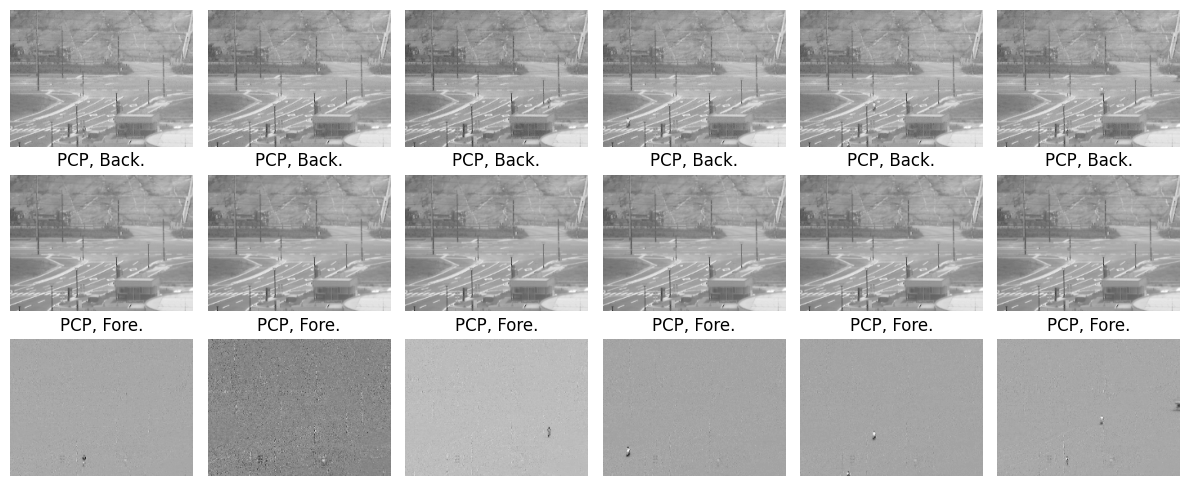

In [27]:
ncols = 6
fig, axs = plt.subplots(3, ncols, figsize=(12, 5))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    background = L_pcp[:, i].reshape(D_res[i].shape)
    foreground = S_pcp[:, i].reshape(D_res[i].shape)
    axs[0, i].imshow(D_res[i], cmap='gray')

    axs[1, i].imshow(background, cmap='gray')
    axs[1, i].set_title("PCP, Back.")

    axs[2, i].imshow(foreground, cmap='gray')
    axs[2, i].set_title("PCP, Fore.")

fig.tight_layout()

Stable PCP

In [28]:
st_pcp = StablePCP()
mu = st_pcp.default_mu(data_mat, sigma=10)
L_st_pcp, S_st_pcp = st_pcp.decompose(data_mat, mu, tol=1e-5, max_iter=500)

Elapsed: 7.75


In [29]:
f'Intrisic rank: {np.linalg.matrix_rank(L_st_pcp)} | Original rank: {np.linalg.matrix_rank(data_mat)} | Fraction of outliers: {(S_st_pcp != 0).mean():.3f}'

'Intrisic rank: 1 | Original rank: 100 | Fraction of outliers: 0.008'

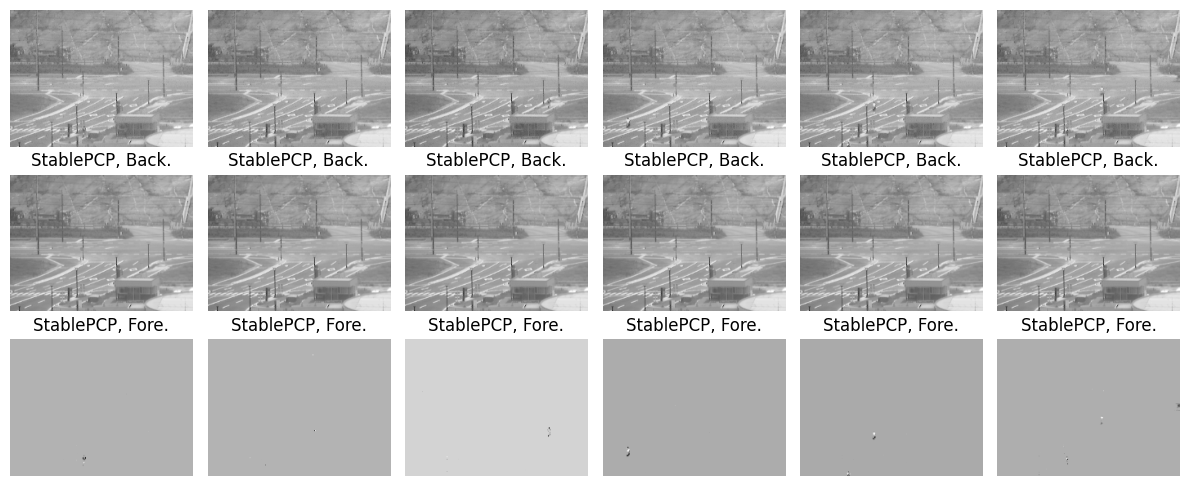

In [30]:
ncols = 6
fig, axs = plt.subplots(3, ncols, figsize=(12, 5))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    axs[0, i].imshow(D_res[i], cmap='gray')

    background = L_st_pcp[:, i].reshape(D_res[i].shape)
    foreground = S_st_pcp[:, i].reshape(D_res[i].shape)
    axs[1, i].imshow(background, cmap='gray')
    axs[1, i].set_title("StablePCP, Back.")
    axs[2, i].imshow(foreground, cmap='gray')
    axs[2, i].set_title("StablePCP, Fore.")

fig.tight_layout()

IRCUR

In [32]:
pcp_alm = IRCUR()
rank = 2
c = 4
nrows, ncols = int(c * rank * np.log(data_mat.shape[0])), int(c * rank * np.log(data_mat.shape[1]))
L_ircur, S_ircur = pcp_alm.decompose(data_mat, rank, nrows, ncols, thresholding_decay=0.65, initial_threshold=100, verbose=True, max_iter=500, tol=1e-9)

Iteration: 49, diff: 7.031557204573195e-10, terminating alg.
Elapsed: 7.69


In [33]:
f'Intrisic rank: {np.linalg.matrix_rank(L_ircur)} | Original rank: {np.linalg.matrix_rank(data_mat)} | Fraction of outliers: {(S_ircur != 0).mean():.3f}'

'Intrisic rank: 2 | Original rank: 100 | Fraction of outliers: 1.000'

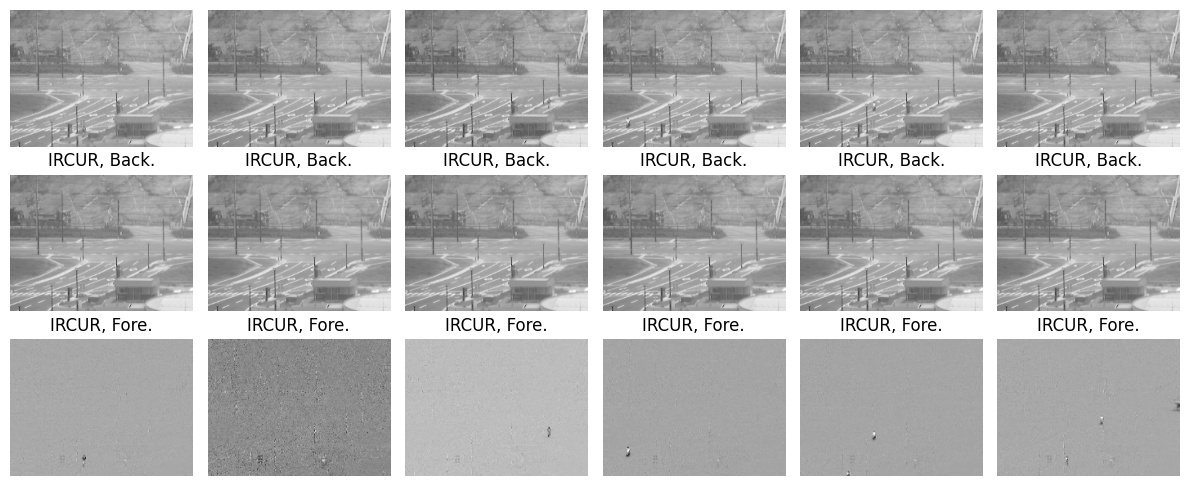

In [34]:
ncols = 6
fig, axs = plt.subplots(3, ncols, figsize=(12, 5))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    axs[0, i].imshow(D_res[i], cmap='gray')

    background = L_ircur[:, i].reshape(D_res[i].shape)
    foreground = S_ircur[:, i].reshape(D_res[i].shape)
    axs[1, i].imshow(background, cmap='gray')
    axs[1, i].set_title("IRCUR, Back.")
    axs[2, i].imshow(foreground, cmap='gray')
    axs[2, i].set_title("IRCUR, Fore.")

fig.tight_layout()

# Problem 3.

Complete the missing data of the image that has 15% sampling.

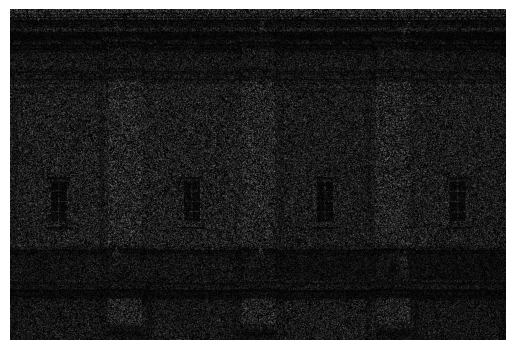

In [35]:
og = cv2.imread("building_mask.png")
plt.axis('off')
plt.imshow(og)

In [38]:
def svd_reconst(given_image, mask_known, rank_svd, num_iterations=10, tol_convergence=1e-4):
    # Find the data we already know
    known_pixel_mean = np.nanmean(given_image[mask_known])
    filled_data = np.where(mask_known, given_image, known_pixel_mean)

    ncols = 5
    fig, axs = plt.subplots(1, ncols, figsize=(15, 5))

    for ax in axs.flatten():
        ax.axis('off')

    for iter_num in range(num_iterations):
        # Apply SVD
        u, singular_values, vt = np.linalg.svd(filled_data, full_matrices=False)
        singular_values[rank_svd:] = 0
        s = np.diag(singular_values)
        low_rank_data = np.dot(u, np.dot(s, vt))
        previous_filled_data = filled_data.copy()
        filled_data[~mask_known] = low_rank_data[~mask_known]

        # Display intermediate results
        if iter_num % 2 == 0 and iter_num // 2 < ncols:
            axs[iter_num // 2].imshow(filled_data, cmap='gray')
            axs[iter_num // 2].set_title(f'SVD Iteration {iter_num}')

    plt.axis('off')
    plt.show()

    return filled_data


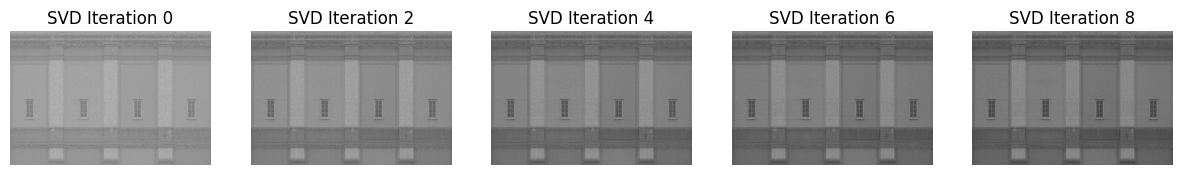

In [39]:
# Read image in gray scale and normalize it
masked_image = np.mean(cv2.imread("building_mask.png"), 2) / 255.0
original_image = np.mean(cv2.imread("building.png"), 2) / 255.0

data_mask = masked_image != 0
approximation_rank = 100
reconstructed_image = svd_reconst(masked_image, data_mask, approximation_rank)


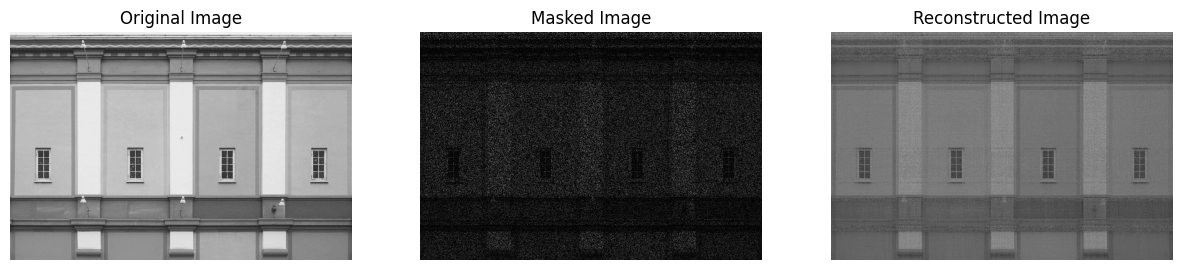

In [40]:

# Display the images
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(masked_image, cmap='gray')
plt.title('Masked Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()